## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you I will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. find the number of rows in the dataset.

In [3]:
df.shape[0]


294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df['converted'] == 1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
new_page_no_treatment = df.query("landing_page == 'new_page' and group != 'treatment'").shape[0]

In [7]:
treatment_no_new_page = df.query("group == 'treatment' and landing_page != 'new_page'").shape[0]

In [8]:
new_page_no_treatment + treatment_no_new_page

3893

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- No missing rows found

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
new_page_and_treatment = "(landing_page == 'new_page' and group == 'treatment')"
old_page_and_control = "(landing_page == 'old_page' and group == 'control')"
df2 = df.query(f"{new_page_and_treatment} or {old_page_and_control}")
df2.shape[0]

290585

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- 773192

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates(subset='user_id', inplace=True)
df2['user_id'].duplicated().sum()

<ipython-input-15-e74f653772a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(subset='user_id', inplace=True)


0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [17]:
(df2['converted'] == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
(df2.query("group == 'control'")['converted'] == 1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
(df2.query("group == 'treatment'")['converted'] == 1).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

- No sufficient evidence that the new page leads to more conversions, as we haven't yet applied hypothesis testing, and the difference in the probability of conversions between the new page and the old page calculated in **b.** and **c.** are too small. So we have to decide on a boundary for type 1 error first, do our hypothesis test, calculate the p-value, then compare it with the type 1 error and see if we will reject or fail to reject our null hypothesis that should state that **the conversion from the new page is less than or equal the conversion from the old page** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

- $H_{0}$: $p_{new} - p_{old} \le 0$ 
- $H_{1}$: $p_{new} - p_{old} > 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
# get the ab_data.csv
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [22]:
conversion_rate = (df2['converted'] == 1).mean()
conversion_rate

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

- Under the Null Hypothesis, the conversion rate for $p_{old}$ = the conversion rate for $p_{new}$

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-conversion_rate, conversion_rate])
new_page_converted.mean()

0.12052164338311197

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-conversion_rate, conversion_rate])
old_page_converted.mean()

0.12031746905846882

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0002041743246431471

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-conversion_rate, conversion_rate])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-conversion_rate, conversion_rate])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
                                                                
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

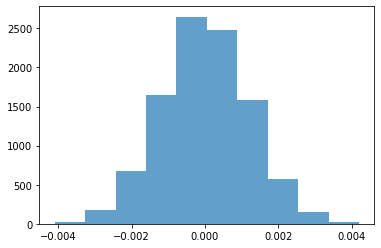

In [29]:
plt.hist(p_diffs, alpha=0.7);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

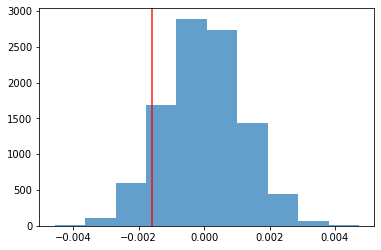

In [30]:
# get the proportion of conversion in the treatment group
p_treatment = (df2[df2['group'] == 'treatment']['converted']).mean()

# get the proportion of conversion in the control group
p_control = (df2[df2['group'] == 'control']['converted']).mean()

# get the actual difference
actual_diff = p_treatment - p_control

# randomly plotting
null_hypoth = np.random.normal(loc=0, scale=np.array(p_diffs).std(), size=10000)
plt.hist(null_hypoth, alpha=0.7)
plt.axvline(x=actual_diff,color='red', alpha=0.9);

In [31]:
# get the p-value
(null_hypoth > actual_diff).mean()

0.9046

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- In part **j.**, we have calculated the p-value. Which is defined as  the probability of observing the statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. The value computed here suggests that we should fail to reject the null hypothesis and stick with the old page as we decided on the type 1 error to be 5% and this value is much greater than this boundary. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
import statsmodels.api as sm

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print("P-Value: ", p_value)
print("Z-Score: ", z_score)


P-Value:  0.9050583127590245
Z-Score:  1.3109241984234394


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- the P-Value and the Z-Score suggest that we should fail to reject the null hypothesis as the P-Value is much greater than the Type I error rate which we decided to be of 5%. And this agrees with the findings found in part **j.** and **k.**.  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

- Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# better work with a copy of the df2 dataframe
df_copy = df2.copy()
df_copy.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:

df_copy[['control', 'treatment']] = pd.get_dummies(df_copy['group'])
df_copy['intercept'] = 1
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   control       290584 non-null  uint8 
 6   treatment     290584 non-null  uint8 
 7   intercept     290584 non-null  int64 
dtypes: int64(3), object(3), uint8(2)
memory usage: 16.1+ MB


In [37]:
df_copy.drop(['control'], axis=1, inplace=True)
df_copy.rename(columns={"treatment": "ab_page"}, inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   ab_page       290584 non-null  uint8 
 6   intercept     290584 non-null  int64 
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
model = sm.Logit(df_copy['converted'],df_copy[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
from scipy import stats
stats.chisqprob = lambda chisq, df_copy: stats.chi2.sf(chisq, df_copy)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:               8.077e-06
Time:                        02:53:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

- p-value = 0.19
- In regression
    - $H_{0}: coef = 0$
    - $H_{1}: coef \ne 0$
- the p-value found in the logistic regression suggest that we should fail to reject the null hypothesis of the regression, or that the coef of **ab_page** is zero. In other words we can say that, **ab_page**(x) variable has no effect on **converted**(y) variable.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- it's a good idea to consider other factors while building a regression model, as our target variable is affected by many factors. For example, in our case, adding the country of the user in our calculations can increase the accuracy of our model.

- Disadvantages:
    - Non-linearity of the response-predictor relationships
    - Correlation of error terms
    - Non-constant Variance and Normally Distributed Errors
    - Outliers/ High leverage points
    - Multicollinearity

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries = pd.read_csv("countries.csv")
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
# merge df_copy and countries dataframes
df_merged = pd.merge(df_copy, countries, how='left', on='user_id')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   ab_page       290584 non-null  uint8 
 6   intercept     290584 non-null  int64 
 7   country       290584 non-null  object
dtypes: int64(3), object(4), uint8(1)
memory usage: 18.0+ MB


In [42]:
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,0,1,US,0,0,1
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,0,1,US,0,0,1
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,0,1,US,0,0,1
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,0,1,US,0,0,1


In [43]:
# drop US column
df_merged.drop('US', axis=1, inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   ab_page       290584 non-null  uint8 
 6   intercept     290584 non-null  int64 
 7   country       290584 non-null  object
 8   CA            290584 non-null  uint8 
 9   UK            290584 non-null  uint8 
dtypes: int64(3), object(4), uint8(3)
memory usage: 18.6+ MB


In [44]:
# fit the model
model = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','CA','UK']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:               2.323e-05
Time:                        02:53:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']

In [46]:
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']

In [47]:
# fit the model
model = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','CA_ab_page','UK_ab_page']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:               3.351e-05
Time:                        02:53:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0183      0.013     -1.449      0.147      -0.043       0.006
CA_ab_page    -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK_ab_page     0.0257      0.019      1.363      0.173      -0.011       0.063
==============================================================================
"""

- The p-values of CA and UK suggest the we should not reject the null hypothesis and that both countries regression coefficent is zero, which means, they have no effect in determining the converted.

### conclusion
- The company should stick with the old page as there's no evidence that the new page is better after utilizing the tests above (Hypothesis and regression)
- Tests should be re-applied after gathering more data to increase our confidence in the decision

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

In [127]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0